# Battery Management System

## Coolant Fluid Temperature Analysis

In [2]:
import numpy as np
import sklearn
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [3]:
excel_file_path = 'AC-110 Characteristics by Temperature.xlsx'
data = pd.read_excel(excel_file_path, skiprows=3, header=0)

In [4]:
data.columns

Index(['Temp C', 'Temp F', 'Kinematic Viscosity, cSt', 'Dynamic Viscosity, cP',
       'Heat Capacity, KJ/Kg/K', 'Heat Capacity, BTU/lb-F', 'Density, g/cc',
       'Density, kg/m3', 'Density, lb/ft3', 'Thermal Conductivity W/m/K',
       'Thermal Conductivity  BTU/ft-hr-F'],
      dtype='object')

## Data Cleaning

In [6]:
removed_columns = ['Temp F','Density, lb/ft3','Heat Capacity, BTU/lb-F', 
                   'Thermal Conductivity  BTU/ft-hr-F', 'Density, g/cc'] 
# Remove Columns with different metric system

column_names = data.columns

if all(name in column_names for name in removed_columns):
    data = data.drop(removed_columns, axis=1)
data.columns

Index(['Temp C', 'Kinematic Viscosity, cSt', 'Dynamic Viscosity, cP',
       'Heat Capacity, KJ/Kg/K', 'Density, kg/m3',
       'Thermal Conductivity W/m/K'],
      dtype='object')

In [7]:
# Transform all units to grams, Celsius, meters, watts

# Rename Heat Capacity column to show the information in J/g·C
# Rename Density column to show the information in g/L
# Rename Temperature column to Show the complete name (Celsius)
# Rename Thermal Conductivity column to show the information in W/m·C
# Rename Kinematic Viscosity column to show the metrics information in cP·L/g
# cP := Centipoise (Units for Dynamic Viscosity)

data.rename(columns={'Heat Capacity, KJ/Kg/K':'Heat Capacity J/g·C',
                     'Density, kg/m3':'Density g/L',
                     'Temp C':'Temperature C',
                     'Thermal Conductivity W/m/K': 'Thermal Conductivity W/m·C',
                     'Kinematic Viscosity, cSt': 'Kinematic Viscosity cP·L/g'}
            ,inplace=True)

In [8]:
# Round up to 4 decimals 
data = data.apply(lambda x: round(x, 4) if x.dtype == 'float64' else x)

In [9]:
# Sort data by Temperature Column
data = data.sort_values(by='Temperature C')

In [10]:
data.head()

,Temperature C,Kinematic Viscosity cP·L/g,"Dynamic Viscosity, cP",Heat Capacity J/g·C,Density g/L,Thermal Conductivity W/m·C
0,-57,16828.6060,14454.2580,1.8453,858.91,0.1414
1,-56,14059.1471,12066.1224,1.8491,858.24,0.1413
2,-55,11793.9966,10114.1776,1.8528,857.57,0.1413
3,-54,9933.5641,8512.0711,1.8566,856.90,0.1412
4,-53,8399.3121,7191.7430,1.8604,856.23,0.1412


In [11]:
data.tail()

,Temperature C,Kinematic Viscosity cP·L/g,"Dynamic Viscosity, cP",Heat Capacity J/g·C,Density g/L,Thermal Conductivity W/m·C
203,146,1.3541,0.9789,2.6130,722.90,0.1299
204,147,1.3416,0.9690,2.6167,722.23,0.1298
205,148,1.3293,0.9592,2.6205,721.56,0.1298
206,149,1.3173,0.9496,2.6243,720.89,0.1297
207,150,1.3054,0.9402,2.6281,720.22,0.1297


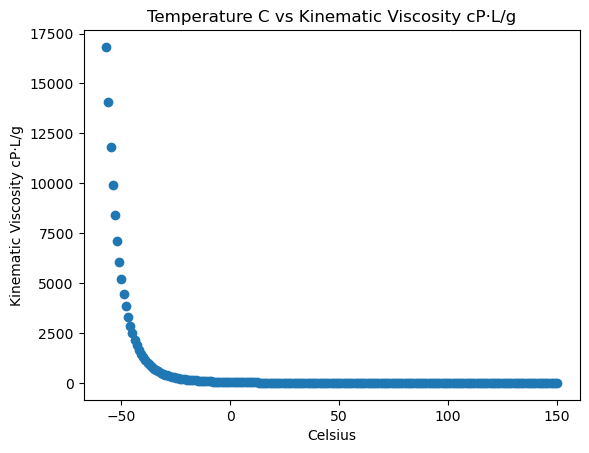

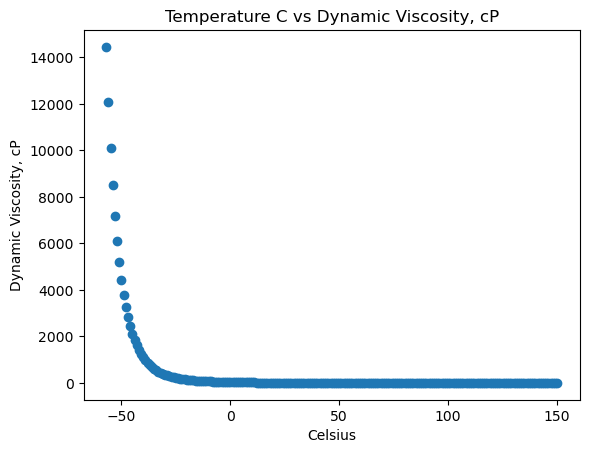

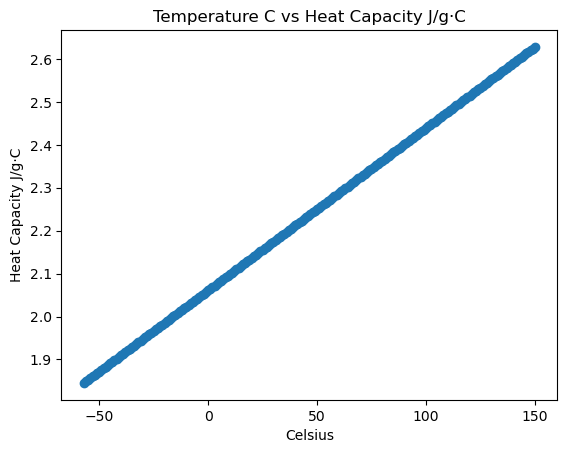

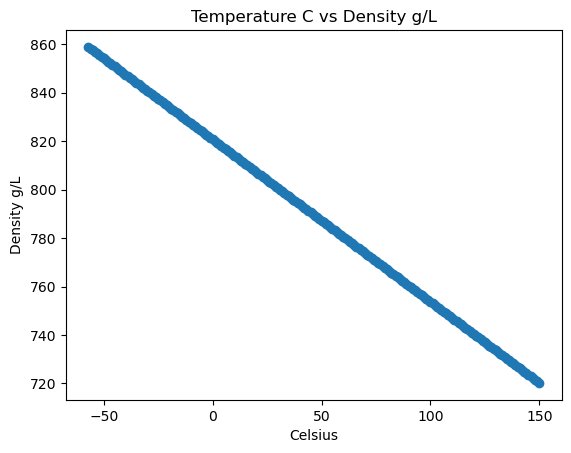

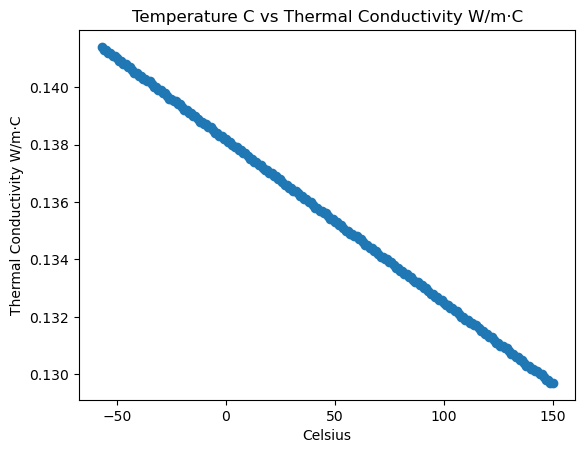

In [12]:
# Get the numeric columns (excluding 'Temp Celsius')
numeric_columns = [column for column in data.columns if column != 'Temperature C' and pd.api.types.is_numeric_dtype(data[column])]

# Create separate plots for each numeric column
for column in numeric_columns:
    plt.figure()
    plt.scatter(data['Temperature C'], data[column])
    plt.xlabel('Celsius')
    plt.ylabel(column)
    plt.title(f'Temperature C vs {column}')

plt.show()

## Describe Temperature Relationships using elemental Mathematical Functions

In [14]:
from scipy.optimize import curve_fit

def inverse_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

def line(x, a, b):
    return a * x + b

# data with dynamic viscosity below 1000
dyn_vis_bel_1000 = data[data['Dynamic Viscosity, cP']<1000]

temp = dyn_vis_bel_1000['Temperature C']
dyn_vis = dyn_vis_bel_1000['Dynamic Viscosity, cP']
kin_vis = dyn_vis_bel_1000['Kinematic Viscosity cP·L/g']
density = dyn_vis_bel_1000['Density g/L']
heat_cap = dyn_vis_bel_1000['Heat Capacity J/g·C']
therm_cond = dyn_vis_bel_1000['Thermal Conductivity W/m·C']

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

### Temperature vs Kinematic Viscosity

a: 19.88
b: 0.10
c: 7.51
R²: 0.9973
Root Mean Squared Error: 9.0463


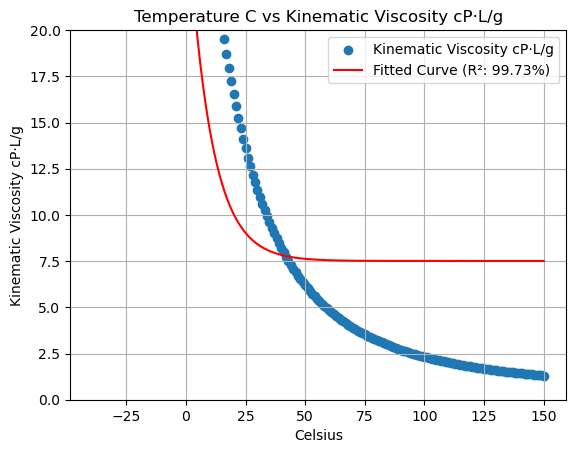

In [17]:
# Perform the curve fitting
params, covariance = curve_fit(inverse_exp, temp, kin_vis)

# Extract the parameters
a, b, c = params
print(f'a: {a:.2f}')
print(f'b: {b:.2f}')
print(f'c: {c:.2f}')
# Create the fitted curve using the extracted parameters
fitted_curve = inverse_exp(temp, a, b, c)


# Evaluation metrics: R2 score and mean squared error
r2 = r2_score(kin_vis, fitted_curve)
rmse = np.sqrt(mean_squared_error(kin_vis, fitted_curve))

print(f'R\u00b2: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

# Plot the data and the fitted curve
column = 'Kinematic Viscosity cP·L/g'
plt.scatter(temp, kin_vis, label='Kinematic Viscosity cP·L/g')
plt.plot(temp, fitted_curve, label=f'Fitted Curve (R\u00b2: {r2:.2%})', color='red')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel(column)
plt.ylim(0,20)
plt.title(f'Temperature C vs {column}')
plt.grid(True)
plt.savefig('Rep 1/temp_vs_kin_vis.png')
plt.show()

### Temperature vs Dynamic Viscosity

a: 16.28
b: 0.10
c: 6.04
R²: 0.9974
Root Mean Squared Error: 7.5338


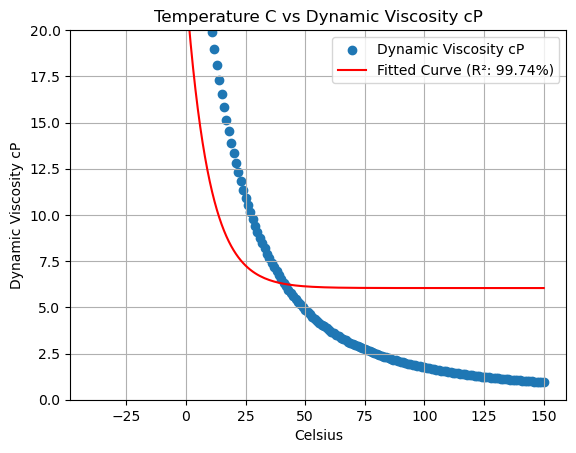

In [19]:
# Perform the curve fitting
params, covariance = curve_fit(inverse_exp, temp, dyn_vis)

# Extract the parameters
a, b, c = params
print(f'a: {a:.2f}')
print(f'b: {b:.2f}')
print(f'c: {c:.2f}')

# Create the fitted curve using the extracted parameters
fitted_curve = inverse_exp(temp, a, b, c)


# Evaluation metrics: R2 score and mean squared error
r2 = r2_score(dyn_vis, fitted_curve)
rmse = np.sqrt(mean_squared_error(dyn_vis, fitted_curve))

print(f'R\u00b2: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


# Plot the data and the fitted curve
column= 'Dynamic Viscosity cP'
plt.scatter(temp, dyn_vis, label='Dynamic Viscosity cP')
plt.plot(temp, fitted_curve, label=f'Fitted Curve (R\u00b2: {r2:.2%})', color='red')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel(column)
plt.title(f'Temperature C vs {column}')
plt.ylim(0,20)
plt.grid(True)
plt.savefig('Rep 1/temp_vs_dyn_vis.png')
plt.show()

### Temperature vs Heat Capacity

a: 0.0038
b: 2.06
R²: 1.0000
Root Mean Squared Error: 0.0000


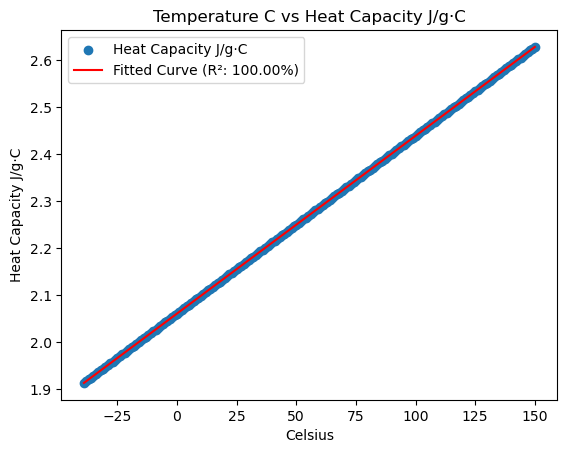

In [21]:
# Perform the curve fitting
params, covariance = curve_fit(line, temp, heat_cap)

# Extract the parameters
a, b = params
print(f'a: {a:.4f}')
print(f'b: {b:.2f}')

# Create the fitted curve using the extracted parameters
fitted_curve = line(temp, a, b)

# Evaluation metrics: R2 score and mean squared error
r2 = r2_score(heat_cap, fitted_curve)
rmse = np.sqrt(mean_squared_error(heat_cap, fitted_curve))

print(f'R\u00b2: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


# Plot the data and the fitted curve
column = 'Heat Capacity J/g·C'
plt.scatter(temp, heat_cap, label='Heat Capacity J/g·C')
plt.plot(temp, fitted_curve, label=f'Fitted Curve (R\u00b2: {r2:.2%})', color='red')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel(column)
plt.title(f'Temperature C vs {column}')
plt.savefig('Rep 1/temp_vs_heat_cap.png')
plt.show()

### Temperature vs Density

a: -0.67
b: 820.72
R²: 1.0000
Root Mean Squared Error: 0.0000


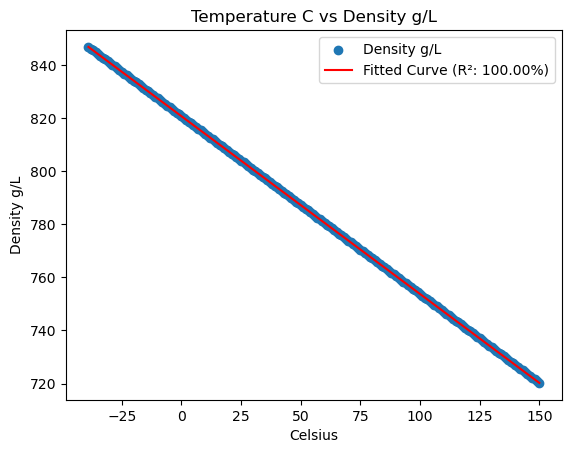

In [23]:
# Perform the curve fitting
params, covariance = curve_fit(line, temp, density)

# Extract the parameters
a, b = params
print(f'a: {a:.2f}')
print(f'b: {b:.2f}')

# Create the fitted curve using the extracted parameters
fitted_curve = line(temp, a, b)

# Evaluation metrics: R2 score and mean squared error
r2 = r2_score(density, fitted_curve)
rmse = np.sqrt(mean_squared_error(density, fitted_curve))

print(f'R\u00b2: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


# Plot the data and the fitted curve
column = 'Density g/L'
plt.scatter(temp, density, label='Density g/L')
plt.plot(temp, fitted_curve, label=f'Fitted Curve (R\u00b2: {r2:.2%})', color='red')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel(column)
plt.title(f'Temperature C vs {column}')
plt.savefig('Rep 1/temp_vs_density.png')
#plt.ylim(0,1000)
plt.show()

### Temperature vs Thermal Conductivity

a: -0.000057
b: 0.14
R²: 0.9999
Root Mean Squared Error: 0.0000


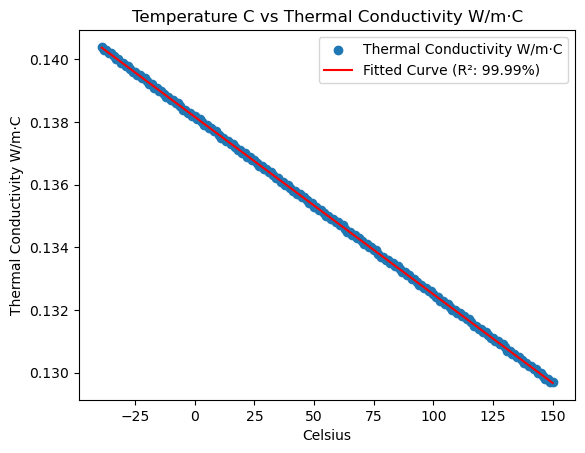

In [25]:
# Perform the curve fitting
params, covariance = curve_fit(line, temp, therm_cond)

# Extract the parameters
a, b = params
print(f'a: {a:.6f}')
print(f'b: {b:.2f}')

# Create the fitted curve using the extracted parameters
fitted_curve = line(temp, a, b)


# Evaluation metrics: R2 score and mean squared error
r2 = r2_score(therm_cond, fitted_curve)
rmse = np.sqrt(mean_squared_error(therm_cond, fitted_curve))

print(f'R\u00b2: {r2:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')



# Plot the data and the fitted curve
column = 'Thermal Conductivity W/m·C'
plt.scatter(temp, therm_cond, label='Thermal Conductivity W/m·C')
plt.plot(temp, fitted_curve, label=f'Fitted Curve (R\u00b2: {r2:.2%})', color='red')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel(column)
plt.title(f'Temperature C vs {column}')
plt.savefig('Rep 1/temp_vs_ther_cond.png')
plt.show()

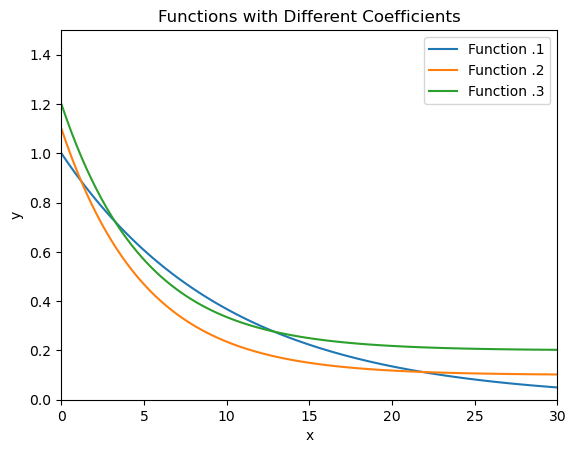

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x values
x = np.linspace(0, 30, 100)

# Define the functions with different coefficients
def f1(x, a):
    return np.exp(-a*x)

def f2(x, a):
    return np.exp(-a*x) + .1

def f3(x, a):
    return np.exp(-a*x) + .2

# Plot the functions
plt.plot(x, f1(x, .1), label='Function .1')
plt.plot(x, f2(x, .2), label='Function .2')
plt.plot(x, f3(x, .2), label='Function .3')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Functions with Different Coefficients')
plt.legend()

# Display the plot
plt.xlim(0,30)
plt.ylim(0,1.5)
plt.show()